# 01_regret_decomposition.ipynb

**Claim under test:**  
R_T ≈ (G^2/λ)·log T + G·P_T with additivity between static and path terms.

**Grid file:** `grids/01_regret_decomposition.yaml`

**Baseline & conventions**
- Use the STAR schema built by `experiment/utils/duck-db-loader.py`.
- Slice results by `(grid_id, seed)` using `analytics.v_run_summary`.
- Keep plots identical across notebooks; only the *dial* under test changes.
- Reference path-length/regret-decomposition companion analysis for context. :contentReference[oaicite:0]{index=0}

## 0) Imports & paths

In [1]:
from pathlib import Path
import duckdb
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

# go up one level
os.chdir("..")

# project paths (edit if your repo layout differs)
REPO = Path(".").resolve()
RESULTS_GLOB = "results_parquet/events/grid_id=*/seed=*/*.parquet"  # corrected pattern
DB_PATH = REPO/"artifacts"/"star.duckdb"
DB_PATH.parent.mkdir(parents=True, exist_ok=True)

GRID_FILE = REPO/"grids/01_regret_decomposition.yaml"     # this notebook's grid
STAGING_TABLE = "staging.events"   # keep default from loader

## 1) Build/load the STAR schema

In [2]:
from utils.duck_db_loader import load_star_schema

con = load_star_schema(
    input_path=str(RESULTS_GLOB),
    db_path=str(DB_PATH),
    staging_table=STAGING_TABLE,
    run_ddl=True,
    create_events_view=True,
)

# sanity: counts
display(con.execute("""
SELECT 'dim_run' t, COUNT(*) c FROM analytics.dim_run
UNION ALL SELECT 'fact_event', COUNT(*) FROM analytics.fact_event
UNION ALL SELECT 'dim_event_type', COUNT(*) FROM analytics.dim_event_type
""").df())

Found 250 files matching pattern: results_parquet/events/grid_id=*/seed=*/*.parquet
  1afea7c370b74535bc15601e6cecacbd-0.parquet: 84 columns
  e1110c921d2b43fd8c7e650163ced1ba-0.parquet: 84 columns
  68ac0914d2814d479f77d4736590c8ff-0.parquet: 84 columns
  cc6c7f5ce244456dae4588d9f83562fc-0.parquet: 84 columns
  ef28438702014107bc30ba799aa60c1f-0.parquet: 84 columns
  da32720c20d246d6a4ff2cfe5f531c5d-0.parquet: 84 columns
  6d60c352d4ca40dea096f89597c01259-0.parquet: 84 columns
  3f52971867ea4268920579631549b39c-0.parquet: 84 columns
  b42acf414e7045238a2c3e20ebf23654-0.parquet: 84 columns
  10fc250a37e74cc589c02e0656836434-0.parquet: 84 columns
  8edf04182533486a9c47e413d680ea9e-0.parquet: 84 columns
  ac5d9df7c34a4dba97cfa149414c04fe-0.parquet: 84 columns
  fea1f8f77aa54772827f50d3e6863fcc-0.parquet: 84 columns
  af12e17d80d94334975d5b5cff0e4560-0.parquet: 84 columns
  fd2d2cfd9d134fd1911dfe45f8102202-0.parquet: 84 columns
  aaf92f016f2f40c390a8f1af98b445ad-0.parquet: 84 columns
  9a

,t,c
0,dim_run,250
1,fact_event,2487500
2,dim_event_type,4


## 2) Snapshot config & runs

In [3]:
runs = con.execute("""
SELECT *
FROM analytics.v_run_summary
ORDER BY grid_id, seed
LIMIT 100
""").df()
runs.head()

,grid_id,seed,run_id,total_events,insert_events,delete_events,avg_regret,min_regret,max_regret,avg_acc,...,max_rho_step,avg_rho_spent,min_rho_spent,max_rho_spent,avg_sigma_step,min_sigma_step,max_sigma_step,avg_sigma_delete,min_sigma_delete,max_sigma_delete
0,027bb2a4fddb,0,027bb2a4fddb_0,9950,8288.0,828.0,0.271538,0.0,9.525534,0.627609,...,1.0,0.0,0.0,0.0,201.816842,201.816842,201.816842,201.816842,201.816842,201.816842
1,027bb2a4fddb,1,027bb2a4fddb_1,9950,7337.0,733.0,2.952131,0.0,51.151703,2.042490,...,1.0,0.0,0.0,0.0,413.591060,413.591060,413.591060,413.591060,413.591060,413.591060
2,027bb2a4fddb,2,027bb2a4fddb_2,9950,8011.0,801.0,1.647696,0.0,39.069161,1.527547,...,1.0,0.0,0.0,0.0,324.222728,324.222728,324.222728,324.222728,324.222728,324.222728
3,027bb2a4fddb,3,027bb2a4fddb_3,9950,0.0,0.0,11.566739,0.0,160.991427,4.036869,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,027bb2a4fddb,4,027bb2a4fddb_4,9950,0.0,0.0,7.266414,0.0,122.232238,3.283001,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# query the analytics.fact_event and analytics.dim_run tables
events = con.execute("SELECT * FROM analytics.fact_event LIMIT 10").df()
parameters = con.execute("SELECT * FROM analytics.dim_parameters LIMIT 10").df()

# print the column names of both dataframes
print(events.columns)
print(parameters.columns)


Index(['grid_id', 'seed', 'event_id', 'event_type', 'D_hat', 'stepsize_params',
       'c_hat', 'drift_threshold', 'oracle_stalled_count',
       'noise_regret_increment', 'segment_id', 'rho_spent',
       'drift_boost_remaining', 'C_hat_1', 'x_norm', 'static_regret_increment',
       'sample_id', 'rho_step', 'oracle_w_norm', 'path_regret_increment',
       'P_T_true', 'eps_spent', 'sc_active', 'oracle_refreshes',
       'capacity_remaining', 'G_hat', 'sigma_step_theory',
       'drift_episodes_count', 'noise_regret_cum', 'P_T', 'sigma_step',
       'P_T_est', 'privacy_spend_running', 'd_norm', 'm_used', 'pair_damped',
       'accountant_type', 'S_scalar', 'accountant', 'regret', 'drift_detected',
       'regret_static_term', 'eps_remaining', 'drift_flag',
       'oracle_refresh_step', 'eps_step_theory', 'ST_running', 'sens_delete',
       'sigma_delete', 'clip_applied', 'comparator_type', 'delta_step_theory',
       'rho_remaining', 'regret_path_term', 'lambda_est', 'regret_increment'

## 3) Standard query helpers

In [5]:
def last_event_frame(con, grid_id:str, seed:int):
    return con.execute("""
    WITH last AS (
      SELECT MAX(event_id) AS last_id
      FROM analytics.fact_event fe
      WHERE fe.grid_id = ? AND fe.seed = ?
    )
    SELECT fe.*
    FROM analytics.fact_event fe
    CROSS JOIN last l
    WHERE fe.event_id = l.last_id AND fe.grid_id = ? AND fe.seed = ?
    """, [grid_id, seed, grid_id, seed]).df()

def trace_frame(con, grid_id:str, seed:int, cols:tuple[str,...]):
    col_list = ", ".join(cols)
    return con.execute(f"""
    SELECT event_id, {col_list}
    FROM analytics.fact_event fe
    WHERE fe.grid_id = ? AND fe.seed = ?
    ORDER BY event_id
    """, [grid_id, seed]).df()

## 4) Plots (standardized)
Keep styling consistent across notebooks for visual comparability.

In [6]:
def plot_traces(df, ycols, title):
    for y in ycols:
        plt.figure()
        plt.plot(df["event_id"], df[y], label=y)
        plt.xlabel("event_id"); plt.ylabel(y); plt.title(f"{title}: {y}")
        plt.legend(); plt.show()

## 5) Notebook-specific check: claim, dial, metrics

Claim under test: R_T ≈ (G^2/λ)·log T + G·P_T with additivity between static and path terms.
Example run: 027bb2a4fddb 0


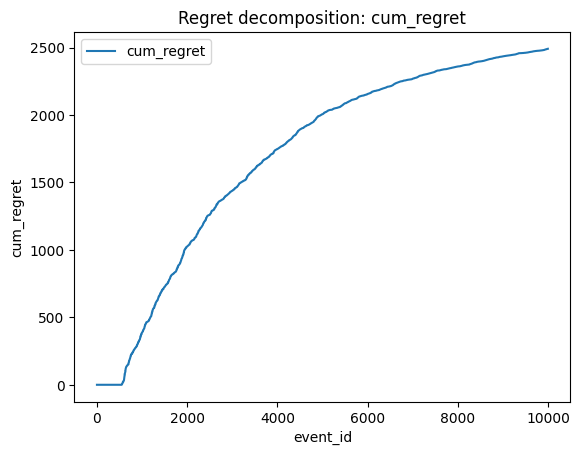

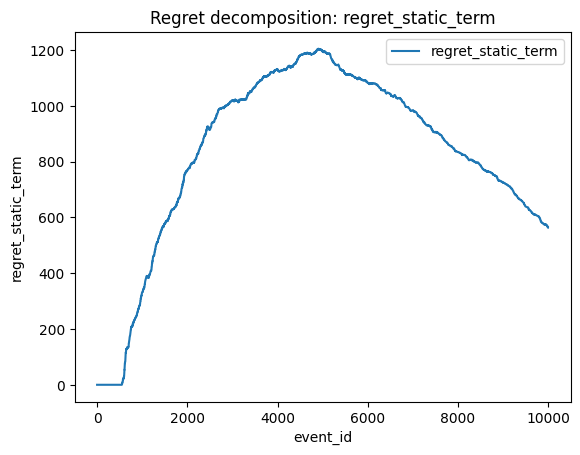

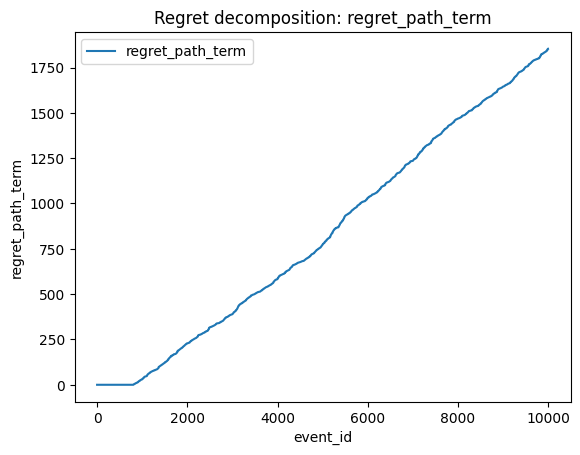

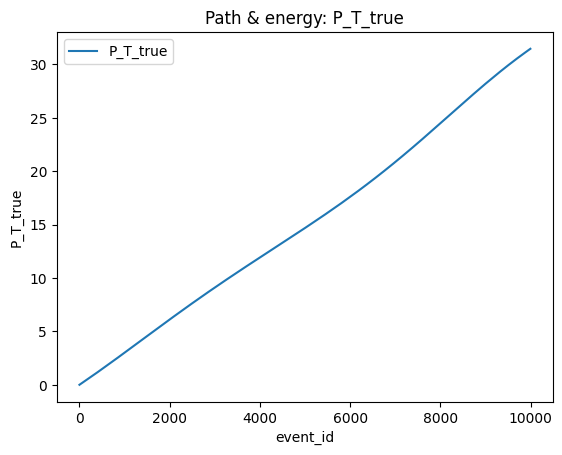

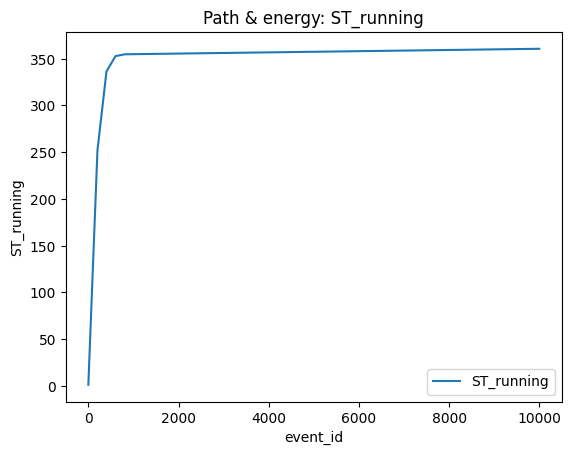

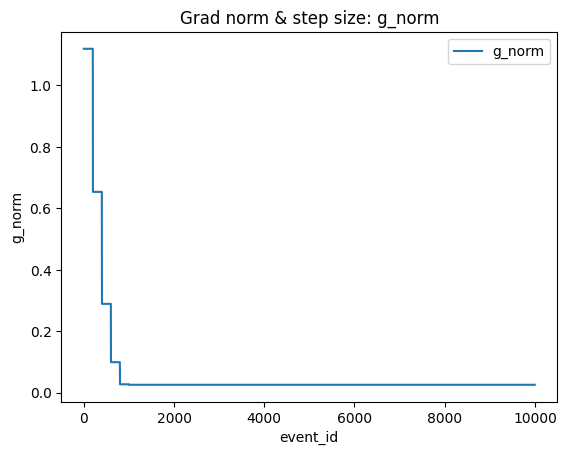

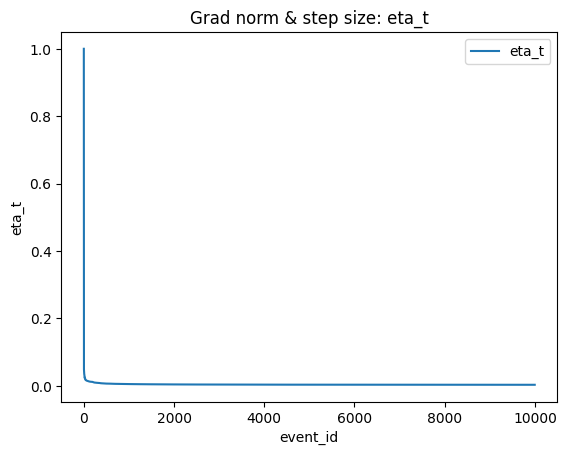

,cum_regret,cum_regret_with_noise,P_T_true,ST_running,rho_spent,m_used
0,2491.021125,2491.021125,31.466027,360.603496,0.0,0


In [7]:
NOTEBOOK_CLAIM = "R_T ≈ (G^2/λ)·log T + G·P_T with additivity between static and path terms."
print("Claim under test:", NOTEBOOK_CLAIM)

# choose a (grid_id, seed) to visualize (edit if multiple)
if not runs.empty:
    gid, seed = runs.loc[0, ["grid_id","seed"]]
    print("Example run:", gid, seed)

    # universal traces
    df = trace_frame(con, gid, int(seed), (
        "cum_regret", "regret_static_term", "regret_path_term",
        "P_T_true", "ST_running", "g_norm", "eta_t"
    ))
    plot_traces(df, ["cum_regret","regret_static_term","regret_path_term"], "Regret decomposition")
    plot_traces(df, ["P_T_true","ST_running"], "Path & energy")
    plot_traces(df, ["g_norm","eta_t"], "Grad norm & step size")

    # end-of-run snapshot
    tail = last_event_frame(con, gid, int(seed))
    display(tail[["cum_regret","cum_regret_with_noise","P_T_true","ST_running","rho_spent","m_used"]])

## 6) One-page “claim check” (export)
Emits a compact JSON summary to artifacts/ for CI diffs.

In [8]:
ARTIFACT = REPO/"artifacts"/(Path("01_regret_decomposition.ipynb").stem + "_claim_check.json")
ARTIFACT.parent.mkdir(parents=True, exist_ok=True)

summary = con.execute("""
SELECT
  fe.grid_id, fe.seed,
  MAX(fe.cum_regret) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event fe2 WHERE fe2.grid_id = fe.grid_id AND fe2.seed = fe.seed)) AS final_cum_regret,
  MAX(fe.cum_regret_with_noise) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event fe2 WHERE fe2.grid_id = fe.grid_id AND fe2.seed = fe.seed)) AS final_cum_regret_with_noise,
  MAX(fe.P_T_true) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event fe2 WHERE fe2.grid_id = fe.grid_id AND fe2.seed = fe.seed)) AS final_P_T_true,
  MAX(fe.ST_running) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event fe2 WHERE fe2.grid_id = fe.grid_id AND fe2.seed = fe.seed)) AS final_ST_running,
  MAX(fe.rho_spent) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event fe2 WHERE fe2.grid_id = fe.grid_id AND fe2.seed = fe.seed)) AS final_rho_spent,
  MAX(fe.m_used) FILTER (WHERE fe.event_id = (SELECT MAX(event_id) FROM analytics.fact_event fe2 WHERE fe2.grid_id = fe.grid_id AND fe2.seed = fe.seed)) AS final_m_used
FROM analytics.fact_event fe
GROUP BY fe.grid_id, fe.seed
ORDER BY fe.grid_id, fe.seed
""").df().to_dict(orient="records")

ARTIFACT.write_text(json.dumps({
    "notebook": "01_regret_decomposition.ipynb",
    "claim": NOTEBOOK_CLAIM,
    "grid_file": str(GRID_FILE),
    "summary": summary
}, indent=2))
print("Wrote:", ARTIFACT)

Wrote: /workspaces/unlearning-research-meta/experiment/artifacts/01_regret_decomposition_claim_check.json
